In [1]:
use_cuda_numpy = False
if use_cuda_numpy:
    import numpy as np
    import matplotlib.pyplot as plt
    import cupy as cnp
    import cupyx.scipy as csp
    import cupyx.scipy.sparse.linalg as clg
    import cupyx.scipy.sparse as csparse
    from time import time
    import os
    
else:
    import numpy as cnp
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy as csp
    import scipy.sparse.linalg as clg
    import scipy.sparse as csparse
    from time import time
    import os

# 2D Time Dependent Schrödinger Equation

### Routines

In [2]:
#Discretized Hamiltonian as a Sparse Matrix
def cuda_get_discrete_U_L(Nx, Ny, dx, dy, dt, mx, my, hbar):
    # it is faster to prepare the diagonals with cpu and then transfer them to gpu
    # since the implementation is very sequential as it is
    # all arguments expected to be in cpu
    # but returned sparse matrix is in gpu
    main_diagonal = 1+1j*dt*0.5*hbar*(1/dx**2/mx+1/dy**2/my)*cnp.ones(Nx*Ny, dtype=complex_dtype)
    for i in range(Nx):
        for j in range(Ny):
            main_diagonal[j*Nx+i] += 1j*dt*V_ij[i,j]/2/hbar
    x_diagonals = -1j*dt*hbar/(4*mx*dx**2)*cnp.ones(Nx*Ny-1, dtype=complex_dtype)
    y_diagonals = -1j*dt*hbar/(4*my*dy**2)*cnp.ones(Nx*(Ny-1), dtype=complex_dtype)
    # There are some zeros we need to place in these diagonals
    for j in range(Ny-1):
        x_diagonals[(j+1)*Nx-1] = 0
    
    return csp.sparse.diags( diagonals=
        (main_diagonal, x_diagonals, x_diagonals,y_diagonals, y_diagonals),
        offsets=np.array([0, 1, -1, Nx, -Nx]), dtype=complex_dtype,format='csc')

### Simulation Parameters

In [3]:
# name for output directories
exp_name = "triki"

# Complex number precision
complex_dtype = cnp.csingle # 64 bit #cnp.cdouble # 128 bit
real_dtype = cnp.single # 32 bit # cnp.double # 64 bit

# hbar, masses
hbar = 1
ms = [1,1]

# Time increment
dt = 0.005

# Number of time iterations
numIts = 800

# Number of points to be used per dimension
Ns = [350,350] # (Nx, Ny, Nz)
Nx,Ny = Ns
 
# Output every
outputEvery = 15

# Number of Bohmian Trajectories to Sample and Evolve
numTrajs = 1000

# Dimensionality of the particles in the 2D configuration space
numDofPartic = 2 # aka a single 2D particle
numDofUniv = 2

# Time grid
ts = np.array([dt*j for j in range(numIts)])

# Intervals for calculating the wave function
xlowers = [-20,-15]
xuppers = [25,15]

# Increments to be used per dimension
dxs = [(xuppers[j]-xlowers[j])/(Ns[j]-1) for j in range(2)] # (dx, dy)
dx,dy = dxs

#Create coordinates at which the solution will be calculated
nodes = [cnp.linspace(xlowers[j], xuppers[j], Ns[j]) for j in range(2)] # (xs, ys)
xs,ys = nodes

print("> Grid Settings:")
print(f"  Using Nx={Ns[0]} Ny={Ns[1]} grid points.")
print(f"  Using dx={dxs[0]:.4} dy={dxs[1]:.4} increments\n")

> Grid Settings:
  Using Nx=350 Ny=350 grid points.
  Using dx=0.1289 dy=0.08596 increments



Save the Simulation Parameters

In [4]:
# Save the Simulation Parameters
os.makedirs(f"./OUTPUTS/TISE_2D/{exp_name}/", exist_ok=True)
with open(f"./OUTPUTS/TISE_2D/{exp_name}/Settings.txt", "w") as f:
    f.write(f"numIts {numIts}\ndt {dt}\noutputEvery {outputEvery}\nNs {Ns}\nxlowers {xlowers}\nxuppers {xuppers}\n")
    f.write(f"numDofUniv {numDofUniv}\nnumDofPartic {numDofPartic}\n")
    f.write(f"numTrajs {numTrajs}\nhbar {hbar}\nms {ms}\nreal_dtype {real_dtype}\ncomplex_dtype {complex_dtype}\n")
    try:
        f.write(f"K_coulomb {K_coulomb} \nqs {qs}\n")
    except:
        f.write(f"K_coulomb {1} \nqs {[1,1,1]}\n")  

### Scenario

In [5]:
def harmonic(grid):
    return cnp.sum(grid**2, -1)

def single_slit_2D(grid, Vmax=30, xbottnk=1, adiabty=2, 
                   wmax=xuppers[1], wmin=1, k_super=6):
    '''wmin is half the slit width
    - wmax>wmin is expected
    - grid supposed to be [Nx,Ny,2]
    - default params for xlowers=[0,-L] xuppers=[2*xbottnk, L]
    - should place adiabaticity<xbottlneck
    '''
    wx = wmax-(wmax-wmin)*cnp.exp(-cnp.abs((grid[:,:,0]-xbottnk)/adiabty)**k_super)
    return Vmax*(1-cnp.exp(-cnp.abs(grid[:,:,1]/wx)**k_super)) #[Nx,Ny]

def double_slit_2D(grid, Vmax=20, k_super=6, 
                   widthxbar=0.3, xbarrier=1, slitSep=2.5,
                  widthSlit=0.7):
    '''
    widths are half widths
    widthSlit should be smaller than half slitSeparation
    '''
    Vy = 1-cnp.exp(-cnp.abs((grid[:,:,1]-slitSep/2)/widthSlit)**k_super)-\
            cnp.exp(-cnp.abs((grid[:,:,1]+slitSep/2)/widthSlit)**k_super)
    return Vmax*cnp.exp(-cnp.abs((grid[:,:,0]-xbarrier)/widthxbar)**k_super)*Vy
    
def double_slit_and_low_screen_2D(grid,Vscreen=6, R_screen=4.5, wscreen=0.2,
                    Vmax=100, k_super=6, 
                   widthxbar=0.5, xbarrier=0, slitSep=1,
                  widthSlit=0.3):
    Vscr = Vscreen*cnp.exp(-cnp.abs((cnp.sqrt(grid[:,:,0]**2+grid[:,:,1]**2)-R_screen)/wscreen)**k_super)
    Vscr = cnp.where(grid[:,:,0]>xbarrier, Vscr, 0)
    Vy = 1-cnp.exp(-cnp.abs((grid[:,:,1]-slitSep/2)/widthSlit)**k_super)-\
            cnp.exp(-cnp.abs((grid[:,:,1]+slitSep/2)/widthSlit)**k_super)
    return Vmax*cnp.exp(-cnp.abs((grid[:,:,0]-xbarrier)/widthxbar)**k_super)*Vy+Vscr

def harmonic_torous_2D(grid, R_torus=7):
    return (cnp.sqrt(grid[:,:,0]**2+grid[:,:,1]**2)-R_torus)**2

In [24]:
K_coulomb=1
qs = [-1,-1]
# Initial Wavefunction
def psi0_gaussian(grid, mus, sigmas, ps, hbar):
    # grid is [Nx,Ny, 2]
    return np.prod(1/(sigmas*np.sqrt(2*np.pi))**0.5*cnp.exp(-(grid-mus)**2/(4*sigmas**2))*cnp.exp(1j*(ps*grid)/hbar), axis=-1, dtype=complex_dtype)

def psi0_gaussian_numpy(x,y, mus, sigmas, ps, hbar):
    return 1/(sigmas[0]*np.sqrt(2*np.pi))**0.5*np.exp(-(x-mus[0])**2/(4*sigmas[0]**2))*\
            1/(sigmas[1]*np.sqrt(2*np.pi))**0.5*np.exp(-(y-mus[1])**2/(4*sigmas[1]**2))*\
                np.exp(1j*(ps[0]*x+ps[1]*y)/hbar)

# parameters for gaussian
mus = cnp.array([-2,0])
sigmas = cnp.array([1,2])
ps = cnp.array([5,0])

# choose the potential and the wavefunction
chosenV=double_slit_2D

# the grid for the potential plot and to allow a speed up using cuda
grid=cnp.array(cnp.meshgrid(*nodes)).T #[Nx,Ny, 2]
V_ij = chosenV(grid)

psi0 = lambda grid: psi0_gaussian(grid, mus=mus, sigmas=sigmas, ps=ps, hbar=hbar)

### Simulation
Prepare Arrays

In [25]:
psi = psi0(grid).flatten('F')

In [27]:
U_L = cuda_get_discrete_U_L(*Ns, *dxs, dt, *ms, hbar)
U_R = U_L.conj()
UL_LUdec = clg.splu( U_L )

In [28]:
# initialize Bohmian trajectories
# first get the pdf
#psi0 = cnp.asnumpy(psi)
pdf0 = (psi.conj()*psi).real
pdf0 = pdf0/pdf0.sum() # normalize strictly

# sample randomly
initial_trajs_idx = cnp.random.choice( pdf0.shape[0], 
            replace=True, size=(numTrajs), p=pdf0 ) #[numTrajs] indices
# need to convert them to positions
j_s = initial_trajs_idx//Nx
i_s = initial_trajs_idx%Nx

# avoiding edges - probability density is zero there
i_s[i_s==0] = 1
i_s[i_s==Ns[0]-1] = Ns[0]-2
j_s[j_s==0] = 1
j_s[j_s==Ns[1]-1] = Ns[1]-2

trajs = cnp.zeros((numTrajs, 4)) #[numTrajs, 4 -2posit2momt]
for tr, (i, j) in enumerate(zip(i_s,j_s)):
    trajs[tr, 0] = nodes[0][i]
    trajs[tr, 1] = nodes[1][j]
    
cdxs = cnp.array(dxs)[cnp.newaxis,:]
cNs = cnp.array(Ns)[cnp.newaxis, :]
cxlowers = cnp.array(xlowers)[cnp.newaxis, :]
cxuppers = cnp.array(xuppers)[cnp.newaxis, :]
cms = cnp.array(ms)[cnp.newaxis, :]

Visualize chosen potential energy profile and trajectories

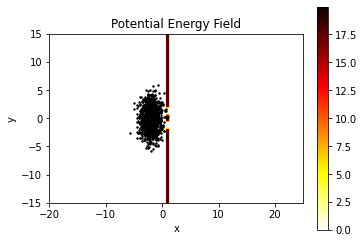

In [29]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
if use_cuda_numpy:
    V_ij=cnp.asnumpy(V_ij)
    trajs_numpy = cnp.asnumpy(trajs)
else:
    trajs_numpy = trajs
    
colormap = ax.imshow(V_ij.T, 
             extent=[xlowers[0], xuppers[0], xlowers[1], xuppers[1]]
                     , origin='lower',cmap='hot_r')
ax.scatter(trajs_numpy[:,0], trajs_numpy[:,1], c="black", s=2,alpha=1)
fig.colorbar(colormap, fraction=0.04, location='right')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Potential Energy Field")
#ax.scatter(trajs[:,0], trajs[:,1], c="black", s=2,alpha=1)
os.makedirs(f"./OUTPUTS/TISE_2D/{exp_name}/figs/", exist_ok=True)
image=f"./OUTPUTS/TISE_2D/{exp_name}/figs/energy_potential.png"
plt.savefig(image, dpi=120, bbox_inches='tight')
plt.show()

Create Directories

In [12]:
os.makedirs(f"./OUTPUTS/TISE_2D/{exp_name}/pdf/", exist_ok=True)
os.makedirs(f"./OUTPUTS/TISE_2D/{exp_name}/trajs/", exist_ok=True)
os.makedirs(f"./OUTPUTS/TISE_2D/{exp_name}/moms/", exist_ok=True)

Run Iterations

In [30]:
dpsi_dx = cnp.zeros(Ns, dtype=complex_dtype)
dpsi_dy = cnp.zeros(Ns, dtype=complex_dtype)
p = cnp.zeros(dpsi_dx.shape+(2, ), dtype=real_dtype) #[ Nx, Ny, 2]

for it, t in enumerate(ts):
    psi_tensor = psi.reshape(Ns[::-1]).swapaxes(0,-1) #[Nx,Ny]
    
    # BOHMIAN MOMENTUM FIELD #####################################
    # first the gradient of the wavefunction at each point
    # X
    # boundaries with simple Euler formula O(dx)
    dpsi_dx[0, :] = (psi_tensor[1, :]-psi_tensor[0, :])/dx
    dpsi_dx[-1, :] = (psi_tensor[-1, :]-psi_tensor[-2, :])/dx
    # next boundaries with centered difference O(dx**2)
    dpsi_dx[1,:] = (psi_tensor[2,:]-psi_tensor[0,:])/(2*dx)
    dpsi_dx[-2,:] = (psi_tensor[-1,:]-psi_tensor[-3,:])/(2*dx)
    # rest with O(dx**4) centered difference
    dpsi_dx[2:-2,:] = (-psi_tensor[4:,:]+8*psi_tensor[3:-1,:]-8*psi_tensor[1:-3,:]+psi_tensor[:-4,:])/(12*dx)

    # DY
    # boundaries with simple Euler formula O(dx)
    dpsi_dy[:, 0] = (psi_tensor[:,1]-psi_tensor[:,0])/dy
    dpsi_dy[:,-1] = (psi_tensor[:,-1]-psi_tensor[:,-2])/dy
    # next boundaries with centered difference O(dx**2)
    dpsi_dy[:,1] = (psi_tensor[:,2]-psi_tensor[:,0])/(2*dy)
    dpsi_dy[:,-2] = (psi_tensor[:,-1]-psi_tensor[:,-3])/(2*dy)
    # rest with O(dx**4) centered difference
    dpsi_dy[:,2:-2] = (-psi_tensor[:,4:]+8*psi_tensor[:,3:-1]-8*psi_tensor[:,1:-3]+psi_tensor[:,:-4])/(12*dy)

    # px, py, pz
    p[:,:,0] = hbar*(dpsi_dx/psi_tensor).imag
    p[:,:,1] = hbar*(dpsi_dy/psi_tensor).imag

    
    # MOMENTUM ON TRAJS TRAJS ##################################################
    # if no trajectory surpasses below the node 0 or J-1 at any time, 
    # traj will always be among (0,J-1) and traj//dxs will be among [0,J-1]
    trajs_idxs = (((trajs[:,:2]-cxlowers)//cdxs).T).astype(cnp.uint) # [2, numTrajs] the closest index from below along each axis
    # relative distance to the closest index from below point along each dimension
    # the closer, the bigger its weight should be for the trajectory propagation
    ratx_down = ((trajs[:,0]-xs[ trajs_idxs[0] ])/(xs[ trajs_idxs[0]+1 ]-xs[ trajs_idxs[0] ]))[:,cnp.newaxis]
    raty_down = ((trajs[:,1]-ys[ trajs_idxs[1] ])/(ys[ trajs_idxs[1]+1 ]-ys[ trajs_idxs[1] ]))[:,cnp.newaxis]
    # Interpolate momentum
    trajs[:,2:] = ratx_down*raty_down* p[ trajs_idxs[0]+1, trajs_idxs[1]+1 ] +\
        (1-ratx_down)*raty_down* p[ trajs_idxs[0], trajs_idxs[1]+1] +\
        ratx_down*(1-raty_down)* p[ trajs_idxs[0]+1, trajs_idxs[1] ] +\
        (1-ratx_down)*(1-raty_down)* p[ trajs_idxs[0], trajs_idxs[1]]
    # Before moving the trajectories, we save the state (with the positions and velocities of this time)
    # OUTPUT #####################################################
    if it%outputEvery == 0:
        print(f"\n > It {it}/{numIts}")
        # compute the magnitude squared of the wavefunction
        pdf = (psi_tensor.conj()*psi_tensor).real
        # Approximate the norm
        print(f"   Iteration {it} Approx.Norm = {pdf.sum()*dx*dy:.4}")
        if use_cuda_numpy:
            pdf = cnp.asnumpy(pdf)
            trajs_numpy = cnp.asnumpy(trajs)
            p_numpy = cnp.asnumpy(p)
        else:
            trajs_numpy = trajs
            p_numpy = p
        np.save(f"./OUTPUTS/TISE_2D/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                pdf, allow_pickle=True) #[Nx,Ny]
        np.save(f"./OUTPUTS/TISE_2D/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                trajs_numpy, allow_pickle=True) #[numTrajs, 4]
        np.save(f"./OUTPUTS/TISE_2D/{exp_name}/moms/momentum_field_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy",
                p_numpy, allow_pickle=True) #[Nx,Ny, 2]    
    # NEXT TIME ITERATION POSITIONS ##############################################
    # Evolve trajectories using the interpolated momentum field
    trajs[:,:2] = trajs[:,:2] + dt*trajs[:,2:]/cms #[numTrajs, 4]
    
    # Those trajectories that get out of bounds should bounce back by the amount they got out
    while(cnp.any(trajs[:,:numDofUniv]>=cxuppers) or cnp.any(trajs[:,:numDofUniv]<=cxlowers)):
        trajs[:,:2] = cnp.where( trajs[:,:2]>cxuppers, cxuppers-(trajs[:,:2]-cxuppers) ,trajs[:,:2] )
        trajs[:,:2] = cnp.where( trajs[:,:2]<cxlowers, cxlowers+(cxlowers-trajs[:,:2]) ,trajs[:,:2] )   
            
    # NEXT PSI ####################################################
    # compute the next time iteration's wavefunction
    U_Rpsi_prev = U_R@psi # this is the vector b in Ax=b
    psi = UL_LUdec.solve(U_Rpsi_prev)


/tmp/ipykernel_33406/4111039331.py:31: RuntimeWarning: divide by zero encountered in true_divide
  p[:,:,0] = hbar*(dpsi_dx/psi_tensor).imag
/tmp/ipykernel_33406/4111039331.py:31: RuntimeWarning: overflow encountered in true_divide
  p[:,:,0] = hbar*(dpsi_dx/psi_tensor).imag
/tmp/ipykernel_33406/4111039331.py:31: RuntimeWarning: invalid value encountered in true_divide
  p[:,:,0] = hbar*(dpsi_dx/psi_tensor).imag
/tmp/ipykernel_33406/4111039331.py:32: RuntimeWarning: divide by zero encountered in true_divide
  p[:,:,1] = hbar*(dpsi_dy/psi_tensor).imag
/tmp/ipykernel_33406/4111039331.py:32: RuntimeWarning: overflow encountered in true_divide
  p[:,:,1] = hbar*(dpsi_dy/psi_tensor).imag
/tmp/ipykernel_33406/4111039331.py:32: RuntimeWarning: invalid value encountered in true_divide
  p[:,:,1] = hbar*(dpsi_dy/psi_tensor).imag



 > It 0/800
   Iteration 0 Approx.Norm = 1.0

 > It 15/800
   Iteration 15 Approx.Norm = 1.0

 > It 30/800
   Iteration 30 Approx.Norm = 1.0

 > It 45/800
   Iteration 45 Approx.Norm = 1.0

 > It 60/800
   Iteration 60 Approx.Norm = 1.0

 > It 75/800
   Iteration 75 Approx.Norm = 1.0

 > It 90/800
   Iteration 90 Approx.Norm = 1.0

 > It 105/800
   Iteration 105 Approx.Norm = 1.0

 > It 120/800
   Iteration 120 Approx.Norm = 1.0

 > It 135/800
   Iteration 135 Approx.Norm = 1.0

 > It 150/800
   Iteration 150 Approx.Norm = 1.0

 > It 165/800
   Iteration 165 Approx.Norm = 1.0

 > It 180/800
   Iteration 180 Approx.Norm = 1.0

 > It 195/800
   Iteration 195 Approx.Norm = 1.0

 > It 210/800
   Iteration 210 Approx.Norm = 1.0

 > It 225/800
   Iteration 225 Approx.Norm = 1.0

 > It 240/800
   Iteration 240 Approx.Norm = 1.0

 > It 255/800
   Iteration 255 Approx.Norm = 1.0

 > It 270/800
   Iteration 270 Approx.Norm = 1.0

 > It 285/800
   Iteration 285 Approx.Norm = 1.0

 > It 300/800
 

Free stuff

In [31]:
if use_cuda_numpy:
    cnp.get_default_memory_pool().free_all_blocks()
    cnp.get_default_pinned_memory_pool().free_all_blocks()

### Animation Generation

Generate png

In [32]:
if use_cuda_numpy:
    nodes = [cnp.asnumpy(nodel) for nodel in nodes]

(2, 350, 350)
Using a mesh in the plot of (2, 350, 350)

 > It 0/800

 > It 15/800

 > It 30/800

 > It 45/800

 > It 60/800

 > It 75/800

 > It 90/800

 > It 105/800

 > It 120/800

 > It 135/800

 > It 150/800

 > It 165/800

 > It 180/800

 > It 195/800

 > It 210/800

 > It 225/800

 > It 240/800

 > It 255/800

 > It 270/800

 > It 285/800

 > It 300/800

 > It 315/800

 > It 330/800

 > It 345/800

 > It 360/800

 > It 375/800

 > It 390/800

 > It 405/800

 > It 420/800

 > It 435/800

 > It 450/800

 > It 465/800

 > It 480/800

 > It 495/800

 > It 510/800

 > It 525/800

 > It 540/800

 > It 555/800

 > It 570/800

 > It 585/800

 > It 600/800

 > It 615/800

 > It 630/800

 > It 645/800

 > It 660/800

 > It 675/800

 > It 690/800

 > It 705/800

 > It 720/800

 > It 735/800

 > It 750/800

 > It 765/800

 > It 780/800

 > It 795/800


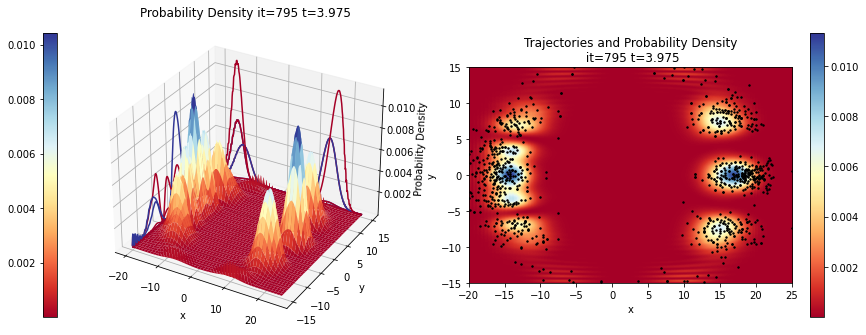

In [33]:
os.makedirs(f"./OUTPUTS/TISE_2D/{exp_name}/figs/", exist_ok=True)
image_paths = []
dpi = 100

every=1 # Only take one data point every this number in each axis to plot
grid=np.array(np.meshgrid(*nodes)).swapaxes(-2,-1)[:,::every, ::every] #[2,Nx::ev,Ny]
print(grid.shape)
print(f"Using a mesh in the plot of {grid.shape}")
fig = plt.figure( figsize=(14,7))

for it, t in enumerate(ts):
    if it%outputEvery==0:
        print(f"\n > It {it}/{numIts}")
        
        fig.clf()
        pdf = np.load(f"./OUTPUTS/TISE_2D/{exp_name}/pdf/pdf_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        trajs = np.load(f"./OUTPUTS/TISE_2D/{exp_name}/trajs/trajs_it_{it}_numIts_{numIts}_dt_{dt:.3}.npy")
        
        ax = fig.add_subplot(121, projection='3d')
        maxim = pdf.max()
        minim = pdf.min()
        # PDF ############################################################
        colormap = ax.plot_surface(grid[0], grid[1], pdf, rcount=50, ccount=50,
                cmap='RdYlBu')
        fig.colorbar(colormap, fraction=0.04, location='left')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("Probability Density")
        ax.set_title(f"Probability Density it={it} t={t:.4}")
        cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='x', 
                          offset=xlowers[0], cmap='RdYlBu', vmax=maxim, vmin=minim)
        cset = ax.contour(grid[0], grid[1], pdf, 7, zdir='y',
                          offset=xuppers[1], cmap='RdYlBu', vmax=maxim, vmin=minim)
       
        # PDF + TRAJECTORIES ##############################################
        ax = fig.add_subplot(122)
        colormap = ax.imshow(pdf.T, 
             extent=[xlowers[0], xuppers[0], xlowers[1], xuppers[1]]
                             , origin='lower',cmap='RdYlBu')
        #plt.axis(aspect='image');
        fig.colorbar(colormap, fraction=0.04, location='right')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Trajectories and Probability Density\n it={it} t={t:.4}")
        ax.scatter(trajs[:,0], trajs[:,1], c="black", s=2,alpha=1)
        
        image=f"./OUTPUTS/TISE_2D/{exp_name}/figs/it_{it}.png"
        plt.savefig(image, dpi=dpi)
        image_paths.append(image)      
        
        


Generate gif

In [34]:
import imageio
fps=5
images_for_animation = [ imageio.v2.imread(image_path) for image_path in image_paths]
imageio.mimsave(f'./OUTPUTS/TISE_2D/{exp_name}/CN_TISE_{exp_name}.gif', images_for_animation, duration=fps**-1*len(images_for_animation))

Erase png

In [ ]:
#for image_path in image_paths:
#    os.remove(image_path)

In [21]:
a=np.array([['i0j0', 'i0j1', 'i0j2'], ['i1j0', 'i1j1', 'i1j2'],['i2j0', 'i2j1', 'i2j2']])
a.flatten('F')

array(['i0j0', 'i1j0', 'i2j0', 'i0j1', 'i1j1', 'i2j1', 'i0j2', 'i1j2',
       'i2j2'], dtype='<U4')